In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import numpy as np
import tensorflow as tf
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
x = np.load('./data/compiled_X_1.npy')
y = np.load('./data/compiled_Y_1.npy')

x_2 = np.load('./data/compiled_X_2.npy')
y_2 = np.load('./data/compiled_Y_2.npy')
with open('./data/y_col_annot.txt', 'r') as f:
    label_annot = [x.strip() for x in f]
    label_annot = {x:i for i,x in enumerate(label_annot)}
label_annot

{'wtCas9_cleave_rate_log': 0,
 'Cas9_enh_cleave_rate_log': 1,
 'Cas9_hypa_cleave_rate_log': 2,
 'Cas9_HF1_cleave_rate_log': 3,
 'wtCas9_cleave_rate_log_specificity': 4,
 'Cas9_enh_cleave_rate_log_specificity': 5,
 'Cas9_hypa_cleave_rate_log_specificity': 6,
 'Cas9_HF1_cleave_rate_log_specificity': 7,
 'wtCas9_ndABA': 8,
 'Cas9_enh_ndABA': 9,
 'Cas9_hypa_ndABA': 10,
 'Cas9_HF1_ndABA': 11}

In [4]:
x = x[:, :, 4:]
x_2 = x_2[:, :, 4:]

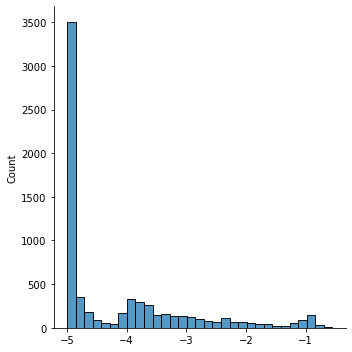

In [5]:
tar_to_train = label_annot['wtCas9_cleave_rate_log']
sns.displot(y[:,tar_to_train])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=777)
x2_train, x2_test, y2_train, y2_test = train_test_split(x_2, y_2, test_size=0.2, random_state=888)

In [7]:
n_channels = 9
n_feats = 25
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(input_shape=(n_feats, n_channels), kernel_size=7, filters=16, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(kernel_size=7, filters=64, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(kernel_size=7, filters=256, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="linear")
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 16)            1024      
_________________________________________________________________
dropout (Dropout)            (None, 25, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 64)            7232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 256)           114944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 256)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3328)              0

In [9]:
model.compile(loss="mae", optimizer="adam")

In [10]:
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                       save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=50,
    verbose=0)

hist = model.fit(x_train,
          y_train[:,tar_to_train],
          batch_size=128,
          callbacks=[checkpointer, earlystopper],
          #validation_split=0.2, 
          validation_data=(x2_train, y2_train[:,tar_to_train]),
          epochs=500,
          verbose=0)
model.load_weights('bestmodel.h5')

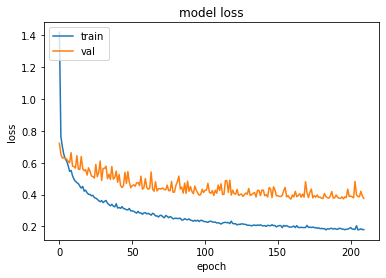

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

spearman SpearmanrResult(correlation=0.9172702900413247, pvalue=6.882270602576606e-281)
pearson (0.9658774649277321, 0.0)


/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Testing prediction, pcc=0.966')

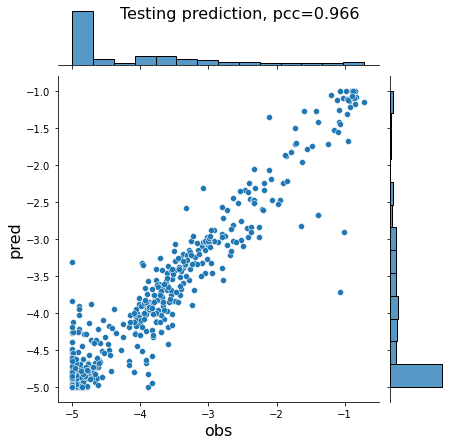

In [12]:
y_hat = model.predict(x_test).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test[:,tar_to_train], y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test[:,tar_to_train]))
p = ss.pearsonr(y_hat, y_test[:,tar_to_train])
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

spearman SpearmanrResult(correlation=0.9138355471308498, pvalue=0.0)
pearson (0.9837541692994453, 0.0)


/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Train fit, pcc=0.984')

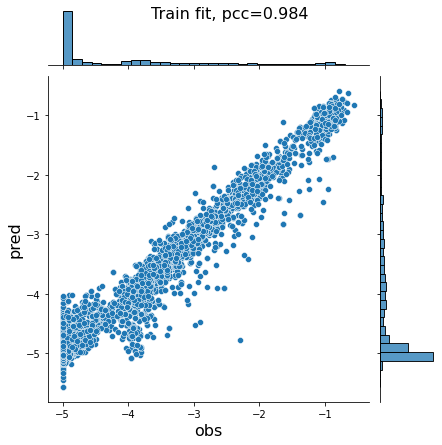

In [13]:
y_fit = model.predict(x_train).flatten()
h = sns.jointplot(y_train[:,tar_to_train], y_fit)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_fit, y_train[:,tar_to_train]))
p = ss.pearsonr(y_fit, y_train[:,tar_to_train])
print("pearson", p)
h.fig.suptitle("Train fit, pcc=%.3f"%p[0], fontsize=16)

spearman SpearmanrResult(correlation=0.7834968939194429, pvalue=0.0)
pearson (0.8591476958078325, 0.0)


/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Validation 2 prediction, pcc=0.859')

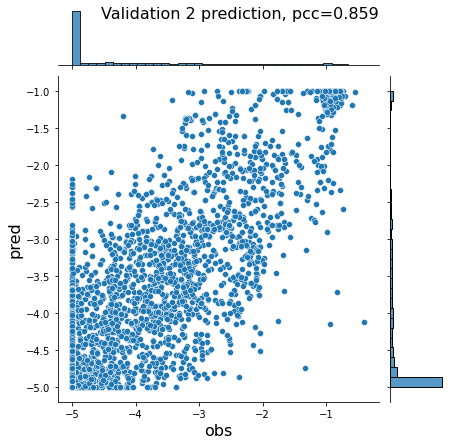

In [14]:
y_val_hat = model.predict(x2_train).flatten()
y_val_hat = np.clip(y_val_hat, -5, -1)

h = sns.jointplot(y2_train[:,tar_to_train], y_val_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_val_hat, y2_train[:,tar_to_train]))
p = ss.pearsonr(y_val_hat, y2_train[:,tar_to_train])
print("pearson", p)
h.fig.suptitle("Validation 2 prediction, pcc=%.3f"%p[0], fontsize=16)

spearman SpearmanrResult(correlation=0.7728572792643096, pvalue=1.3151586213434699e-278)
pearson (0.8552249884110741, 0.0)


/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Testing 2 prediction, pcc=0.855')

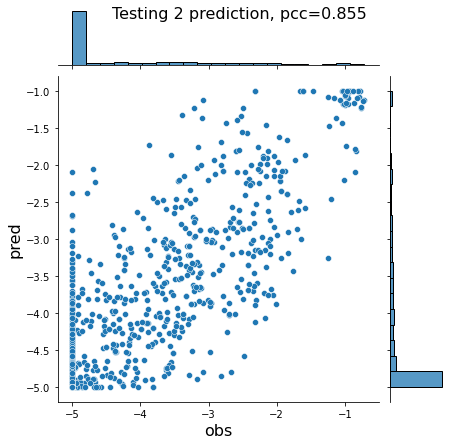

In [15]:
y_hat2 = model.predict(x2_test).flatten()
y_hat2 = np.clip(y_hat2, -5, -1)

h = sns.jointplot(y2_test[:,tar_to_train], y_hat2)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat2, y2_test[:,tar_to_train]))
p = ss.pearsonr(y_hat2, y2_test[:,tar_to_train])
print("pearson", p)
h.fig.suptitle("Testing 2 prediction, pcc=%.3f"%p[0], fontsize=16)

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

matplotlib: 3.4.3
tensorflow: 1.15.0
numpy     : 1.21.6
scipy     : 1.7.3
seaborn   : 0.11.1

Watermark: 2.3.1

